<a href="https://colab.research.google.com/github/hamish-haggerty/cancer-proj/blob/main/cancer_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
!unzip -q "/content/drive/MyDrive/isic-2019.zip" #https://www.kaggle.com/datasets/andrewmvd/isic-2019

Mounted at /content/drive


In [2]:
import os
#os.system('pip install .')
os.system('pip install git+https://github.com/hamish-haggerty/base_rbt.git')
os.system('pip install git+https://github.com/hamish-haggerty/cancer-proj.git')

0

In [11]:
#!pip install -qU git+https://github.com/hamish-haggerty/cancer-proj.git #sometimes os doesn't work so use this if imports below fail

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [1]:
#| export
from fastai.vision.all import *
from base_rbt.all import *
#from cancer_proj.cancer_dataloading import *
from cancer_proj.cancer_metrics import *
from cancer_proj.cancer_maintrain import *
#from cancer_proj.cancer_maintrain_ensemble import *
#from cancer_proj.cancer_maintrain_ce import *
from self_supervised.augmentations import assert_aug_pipelines
from self_supervised.layers import create_mlp_module
from statistics import mean,stdev

import fastai
test_eq(fastai.__version__,'2.7.11')

import torch
test_eq(torch.__version__,'1.13.1+cu116')


In [2]:
directory = "/content/drive/MyDrive/ISIC_2019_Training_Input/"
data = pd.read_csv("/content/drive/MyDrive/ISIC_2019_Training_GroundTruth.csv").drop("UNK", axis=1)
data = data[~data["image"].str.contains("downsampled")]
labels = pd.read_csv("/content/drive/MyDrive/ISIC_2019_Training_GroundTruth.csv")

In [9]:
# import os
# from PIL import Image

# # Set the path to the image you want to load
# image_path = "/content/drive/MyDrive/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000000.jpg"

# # Load the image using PIL
# image = Image.open(image_path)

# # Display the image
# image.show()


#Get data

In [3]:
save_directory = '/content/drive/My Drive/cancer_colab' #directory for saving models etc
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

In [4]:
data_dict = load_dict_from_gdrive(directory=save_directory,filename='data_dict')
_fnames = data_dict['_fnames']
test_eq(len(_fnames),len(data))

In [5]:
# _fnames = get_image_files(directory)
# _fnames = [name for name in _fnames if 'downsampled' not in name.as_posix()]
# len(_fnames)
test_eq(len(_fnames),len(data))

In [10]:
# data_dict = {}
# data_dict['_fnames'] = _fnames

Stuff to process data (labellers etc):

In [6]:
import re


def process_path(name):
    return name.as_posix().split('/')[-1] #basically get end part of Path('...') as a string

def extract_id(string):
    regex = r'ISIC_\d+'
    match = re.search(regex, string)
    if match:
        return match.group(0)
    else:
        return None

def get_class_from_id(string):
    "Given the identifier e.g. ISIC_0000000.jpg return the class label"

    row=data.loc[data['image'] == string]
    lst = [colname for colname in row.columns if row[colname].values==1]
    test_eq(len(lst),1)

    return lst[0]

def get_label_func_dict(_fnames):
    label_func_dict={}
    for name in _fnames:
        label_func_dict[name] = get_class_from_id(extract_id(process_path(name)))

    return label_func_dict

#label_func_dict = get_label_func_dict(_fnames) #can just load this in future to save time
label_func_dict = data_dict['label_func_dict']

def label_func(name):

    return label_func_dict[name]


_labels = [label_func(x) for x in _fnames] 
test_eq(len(_labels),len(_fnames))

# Build training, tuning, validation test sets:
    - Training is unlabelled
    - Tuning is for supervised fine tuning
    - Validation is a held out (proxy) test set
    - Test set is for getting results

In [96]:
#tests / sanity checks:
test_eq(process_path(_fnames[0]),'ISIC_0071718.jpg')
test_eq(process_path(_fnames[10]),'ISIC_0071719.jpg')


fnames_train=[]
labels_train=[]
count_dict={i:0 for i in set(_labels)}

fnames = _fnames[0:5000]
labels = _labels[0:5000]

for i,lab in enumerate(labels):

    if count_dict[lab]<500:
        fnames_train.append(_fnames[i])
        labels_train.append(_labels[i])

    count_dict[lab]+=1

fnames_valid = _fnames[5000:5000+256*5]
labels_valid = _labels[5000:5000+256*5]

fnames_test = get_difference(_fnames,fnames_train+fnames_valid)
fnames_test.sort()
labels_test = [label_func(path) for path in fnames_test]


print(f'Training (tuning) set has: \n{Counter(labels_train)}\n')

print(f'Validation set has: \n{Counter(labels_valid)}\n')

print(f'Test set has: \n{Counter(labels_test)}\n')

#A few tests: Make sure fnames_train and fnames_test the same every time
test_eq(process_path(fnames_train[44]),'ISIC_0071754.jpg')
test_eq(process_path(fnames_test[10]),'ISIC_0000011.jpg')

#Make sure training and valid are disjoint
for path in fnames_valid: assert path not in fnames_train #check that valid set is disjoint from training (tuning) set

#Make sure test and valid+train are disjoint
for path in fnames_test: assert path not in fnames_train+fnames_valid #check that test set is disticnt from training and validation set

Training (tuning) set has: 
Counter({'NV': 500, 'MEL': 500, 'BCC': 500, 'BKL': 467, 'AK': 306, 'SCC': 171, 'VASC': 55, 'DF': 55})

Validation set has: 
Counter({'NV': 458, 'MEL': 309, 'BCC': 274, 'BKL': 110, 'AK': 63, 'SCC': 43, 'VASC': 12, 'DF': 11})

Test set has: 
Counter({'NV': 10601, 'MEL': 3339, 'BCC': 2549, 'BKL': 1663, 'AK': 498, 'SCC': 414, 'VASC': 186, 'DF': 173})



# Setup dataloaders

In [97]:
device ='cuda' if torch.cuda.is_available() else 'cpu'

size=256
item_tfms = [Resize(size)]

item_tfms_train = [Resize(128)]

dls_tune  = ImageDataLoaders.from_path_func(directory, fnames_train, label_func,
                                bs=64,
                                item_tfms=item_tfms,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda')
                                             )


dls_valid  = ImageDataLoaders.from_path_func(directory, fnames_valid, label_func,
                                bs=256,
                                item_tfms=item_tfms,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda')
                                             )


dls_train  = ImageDataLoaders.from_path_func(directory, fnames_train, label_func,
                                bs=128,
                                item_tfms=item_tfms_train,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda')
                                             )


dls_test =  ImageDataLoaders.from_path_func(directory, fnames_test, label_func,
                                bs=64,
                                item_tfms=item_tfms,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda'),
                                shuffle=False
                                )

classes_to_int={v:i for i,v in enumerate(dls_tune.vocab)}
int_to_classes = {i: v for i, v in enumerate(dls_tune.vocab)}
vocab=dls_tune.vocab

In [9]:
classes_to_int={v:i for i,v in enumerate(dls_tune.vocab)}
int_to_classes = {i: v for i, v in enumerate(dls_tune.vocab)}

#Debugging dataloader

In [27]:
_dls =  ImageDataLoaders.from_path_func(directory, fnames_test[0:100], label_func,
                                bs=100,
                                item_tfms=item_tfms,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda'),
                                shuffle=False
                                )

_dls = _dls.train

In [37]:
_xval,_yval = _dls.train.one_batch()

# Aug pipelines

In [10]:
aug_dict = create_aug_pipelines(size=size,device=device,Augs=BYOL_Augs,TUNE_Augs=TUNE_Augs,Val_Augs=Val_Augs)
aug_pipelines = aug_dict['aug_pipelines']
aug_pipelines_tune = aug_dict['aug_pipelines_tune']
aug_pipelines_test = aug_dict['aug_pipelines_test'] 

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 1.0, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.1, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


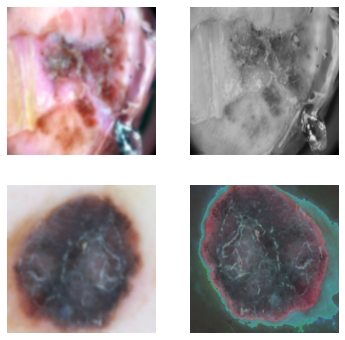

In [ ]:
show_bt_batch(dls_train,n_in=3,n=2,aug=aug_pipelines)

#Train and get results here:

# Fine tune:

In [118]:
def fine_tune(initial_weights,dls_tune,device,encoder=None,epochs=40,tune_model_path=None):
    
    
    if encoder is None: #Generally speaking, this will be None, unless we pretrained an encoder somewhere else and want to pass it in
        _,encoder = create_model(initial_weights,device) #either bt_pretrain, supervised_pretrain etc
    

    print(f'tune_model_path for this run is: {tune_model_path}')
    model = LM(encoder,numout=len(dls_tune.vocab))
    learn = Learner(dls_tune,model,splitter=my_splitter,
                        cbs = [LinearBt(aug_pipelines=aug_pipelines_tune,
                                        n_in=3,tune_model_path=tune_model_path, #if None then don't save
                                    tune_save_after=epochs)],wd=0.0
                        
                   )

    learn.freeze()
    print('Froze head')
    learn.fit(1)
    learn.unfreeze()
    print('Unfroze head')
    lrs = learn.lr_find()
    lr_max=lrs.valley
    print(f'Learning rate finder yielded lr_max: {lr_max}')
    learn.fit_one_cycle(epochs,lr_max)

    return model


def get_dls_metrics(dls,model,int_to_classes): #note that we can't call dls.vocab as it might be smaller on the test set
    "get metrics from model and dataloader"

    ytest,probs,preds,Acc = predict_whole_model(dls,model,aug_pipelines_test,numavg=3)
    metrics = classification_report_wrapper(preds, ytest,int_to_classes, print_report=True)
    
    auc_dict = plot_roc(ytest,preds,int_to_classes,print_plot=True)
    metrics['ytest']=ytest
    metrics['probs']=probs
    metrics['preds']=preds
    metrics['acc']=Acc
    metrics['auc_dict']=auc_dict

    return metrics

def get_xval_metrics(xval,yval,model,aug_pipelines_test,int_to_classes,numavg=3): #note that we can't call dls.vocab as it might be smaller on the test set
    "get metrics from gives batch (xval,yval)"

    probs,preds,Acc = predict_model(xval,yval,model,aug_pipelines_test,numavg=3)
    metrics = classification_report_wrapper(preds, yval,int_to_classes, print_report=True)
    metrics['acc']=Acc

    return metrics

def Mean_Results(results):
    "Get mean classif report and display it"

    lst = list(vocab) + ['accuracy', 'macro avg', 'weighted avg']
    reports=[]
    accs=[]
    for i in results.keys():
        if type(i)!=int:
            continue
        report = {j:results[i][j] for j in results[i].keys() if j in lst}
        reports.append(report)
        accs.append(results[i]['acc'])
    mean_report = Mean_Report(reports,vocab)
    print(format_classification_report(mean_report))
    
    print(f'mean acc is {mean(accs)} with std {stdev(accs)}')

    return mean_report

#fine tune, return the model and path

def main_tune(initial_weights,epochs=40,device='cuda',encoder=None,tune_model_path=None,dict_path=None,description=None,runs=1):

    "Fine tune and save  test results for supervised or bt initial weights"

    if description == None:
        description=f'Fine tuned {weights} initial weights for 40 epochs. Recorded results on test sets. Did this {runs} times'

    if dict_path==None:
        dict_path=f'{weights}_metrics'

    weights = initial_weights.split('_')[0]

    print(f'Description: {description}\n')
    print(f'The general tune model path is: {tune_model_path} (if None mean no saving)')
    print(f'The dict_path is: {dict_path}')

    results={}
    for i in range(runs):

        _tune_model_path = tune_model_path + f'_run{i}'

        fine_tuned = fine_tune(initial_weights,dls_tune,device,encoder=encoder,epochs=epochs,tune_model_path=_tune_model_path)

        #get the metrics
        metrics = get_dls_metrics(dls_test,fine_tuned,int_to_classes)
        print(metrics['acc'])

        #put the path in in the metrics and a short description
        metrics['tune_model_path'],metrics['description'] = tune_model_path,description

        results[i] = metrics

    #save
    if tune_model_path!=None:
        print(f'We are saving the dictionary at {dict_path}') #this is a bug. We saved at f'{weights}_results'
        save_dict_to_gdrive(results,save_directory,f'{weights}_results')

    return results

# Fine tune supervised model, get test set performance:

Assumes that dls_tune, dls_test are constructed above. We fine tune for 40 epochs, and perform 3 runs:

Description: Sup initial weights, 40 epochs

The general tune model path is: /content/drive/My Drive/cancer_colab/initial_weights=supervised_pretrain (if None mean no saving)
The dict_path is: supervised_pretrain
tune_model_path for this run is: /content/drive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run0
Froze head


epoch,train_loss,valid_loss,time
0,1.723776,None,00:17


/usr/local/lib/python3.9/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


Unfroze head


Learning rate finder yielded lr_max: 9.120108734350652e-05


epoch,train_loss,valid_loss,time
0,1.521495,None,00:17
1,1.491078,None,00:17
2,1.449438,None,00:17
3,1.387443,None,00:18
4,1.302584,None,00:17
5,1.198770,None,00:17
6,1.064288,None,00:17
7,0.913039,None,00:17
8,0.753544,None,00:17
9,0.604338,None,00:17


We are saving after true epoch 40 at path /content/drive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run0
              precision    recall  f1-score   support

          AK       0.36      0.52      0.43       498
         BCC       0.68      0.78      0.72      2549
         BKL       0.42      0.49      0.45      1663
          DF       0.34      0.34      0.34       173
         MEL       0.53      0.60      0.56      3339
          NV       0.84      0.71      0.77     10601
         SCC       0.39      0.28      0.32       414
        VASC       0.18      0.67      0.29       186

    accuracy                           0.66     19423
   macro avg       0.47      0.55      0.49     19423
weighted avg       0.70      0.66      0.67     19423

0.6616382598876953
tune_model_path for this run is: /content/drive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run1
Froze head


epoch,train_loss,valid_loss,time
0,1.712082,None,00:17


/usr/local/lib/python3.9/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


Unfroze head


Learning rate finder yielded lr_max: 0.00019054606673307717


epoch,train_loss,valid_loss,time
0,1.505623,None,00:18
1,1.462420,None,00:17
2,1.388521,None,00:17
3,1.289958,None,00:18
4,1.149367,None,00:18
5,0.984500,None,00:18
6,0.803186,None,00:18
7,0.612169,None,00:17
8,0.482417,None,00:17
9,0.355551,None,00:17


We are saving after true epoch 40 at path /content/drive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run1
              precision    recall  f1-score   support

          AK       0.38      0.59      0.46       498
         BCC       0.72      0.75      0.73      2549
         BKL       0.49      0.49      0.49      1663
          DF       0.27      0.29      0.28       173
         MEL       0.50      0.64      0.56      3339
          NV       0.85      0.66      0.74     10601
         SCC       0.31      0.38      0.34       414
        VASC       0.13      0.75      0.22       186

    accuracy                           0.64     19423
   macro avg       0.45      0.57      0.48     19423
weighted avg       0.71      0.64      0.66     19423

0.6444421410560608
tune_model_path for this run is: /content/drive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run2
Froze head


epoch,train_loss,valid_loss,time
0,1.716901,None,00:17


/usr/local/lib/python3.9/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


Unfroze head


Learning rate finder yielded lr_max: 0.00010964782268274575


epoch,train_loss,valid_loss,time
0,1.522152,None,00:17
1,1.480499,None,00:18
2,1.427702,None,00:17
3,1.360272,None,00:17
4,1.271075,None,00:17
5,1.150795,None,00:17
6,1.009295,None,00:18
7,0.843835,None,00:17
8,0.676488,None,00:17
9,0.519064,None,00:18


We are saving after true epoch 40 at path /content/drive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run2
              precision    recall  f1-score   support

          AK       0.35      0.61      0.45       498
         BCC       0.69      0.75      0.72      2549
         BKL       0.48      0.51      0.49      1663
          DF       0.32      0.31      0.31       173
         MEL       0.45      0.64      0.53      3339
          NV       0.86      0.67      0.75     10601
         SCC       0.35      0.31      0.33       414
        VASC       0.31      0.70      0.43       186

    accuracy                           0.65     19423
   macro avg       0.47      0.56      0.50     19423
weighted avg       0.70      0.65      0.66     19423

0.6501055359840393
We are saving the dictionary at supervised_pretrain


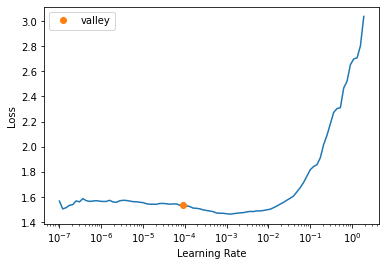

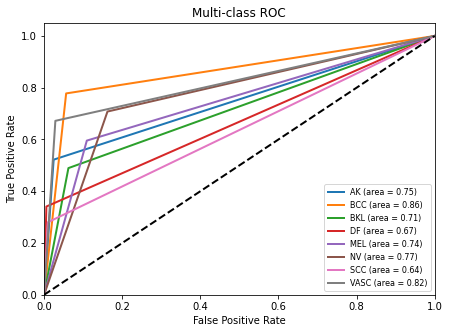

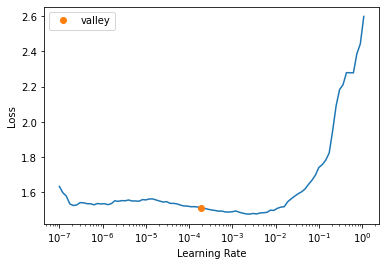

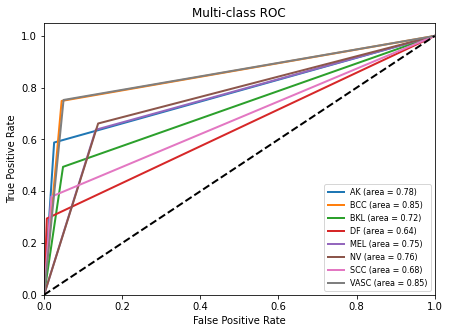

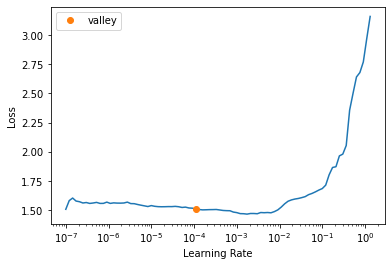

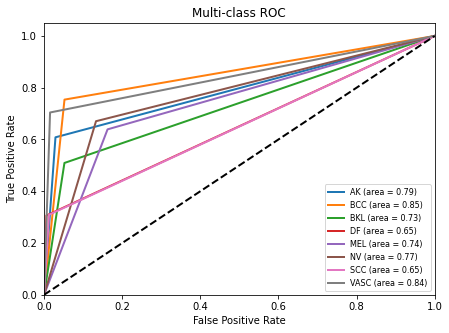

In [32]:
#Hyperparams: description, type of intial weights, number of epochs, number of runs
description = 'Sup initial weights, 40 epochs'
initial_weights='supervised_pretrain'
epochs=40
runs=3

tune_model_path = save_directory + f'/initial_weights={initial_weights}'
dict_path = f'{initial_weights}' #file to load dictionary metadata

sup_results = main_tune(initial_weights,epochs=epochs,device=device, tune_model_path=tune_model_path, dict_path = dict_path,description=description,
          runs=runs
          )

# As above but for BT initial weights:

In [126]:
bt_results=load_dict_from_gdrive(save_directory,'bt_results')

Description: BT initial weights, 40 epochs

The general tune model path is: /content/drive/My Drive/cancer_colab/initial_weights=bt_pretrain (if None mean no saving)
The dict_path is: bt_pretrain


Downloading: "https://github.com/facebookresearch/barlowtwins/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://dl.fbaipublicfiles.com/barlowtwins/ep1000_bs2048_lrw0.2_lrb0.0048_lambd0.0051/resnet50.pth" to /root/.cache/torch/hub/checkpoints/resnet50.pth


  0%|          | 0.00/90.0M [00:00<?, ?B/s]

tune_model_path for this run is: /content/drive/My Drive/cancer_colab/initial_weights=bt_pretrain_run0
Froze head


epoch,train_loss,valid_loss,time
0,1.780663,None,00:17


/usr/local/lib/python3.9/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


Unfroze head


Learning rate finder yielded lr_max: 0.0020892962347716093


epoch,train_loss,valid_loss,time
0,1.597439,None,00:17
1,1.520468,None,00:18
2,1.417066,None,00:18
3,1.280330,None,00:17
4,1.127469,None,00:18
5,0.941388,None,00:17
6,0.764782,None,00:17
7,0.646042,None,00:18
8,0.534301,None,00:17
9,0.467297,None,00:17


We are saving after true epoch 40 at path /content/drive/My Drive/cancer_colab/initial_weights=bt_pretrain_run0
              precision    recall  f1-score   support

          AK       0.37      0.62      0.46       498
         BCC       0.75      0.74      0.75      2549
         BKL       0.48      0.49      0.48      1663
          DF       0.46      0.34      0.39       173
         MEL       0.50      0.63      0.56      3339
          NV       0.85      0.77      0.81     10601
         SCC       0.51      0.30      0.38       414
        VASC       0.55      0.53      0.54       186

    accuracy                           0.70     19423
   macro avg       0.56      0.55      0.55     19423
weighted avg       0.72      0.70      0.71     19423

0.7010245323181152


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


tune_model_path for this run is: /content/drive/My Drive/cancer_colab/initial_weights=bt_pretrain_run1
Froze head


epoch,train_loss,valid_loss,time
0,1.794100,None,00:17


/usr/local/lib/python3.9/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


Unfroze head


Learning rate finder yielded lr_max: 0.0005754399462603033


epoch,train_loss,valid_loss,time
0,1.625527,None,00:17
1,1.607783,None,00:18
2,1.559101,None,00:17
3,1.485719,None,00:17
4,1.401317,None,00:18
5,1.294475,None,00:17
6,1.163948,None,00:17
7,1.024467,None,00:18
8,0.884823,None,00:17
9,0.729437,None,00:17


We are saving after true epoch 40 at path /content/drive/My Drive/cancer_colab/initial_weights=bt_pretrain_run1
              precision    recall  f1-score   support

          AK       0.34      0.53      0.41       498
         BCC       0.71      0.71      0.71      2549
         BKL       0.48      0.49      0.48      1663
          DF       0.36      0.29      0.32       173
         MEL       0.49      0.67      0.56      3339
          NV       0.87      0.76      0.81     10601
         SCC       0.44      0.31      0.37       414
        VASC       0.54      0.39      0.45       186

    accuracy                           0.69     19423
   macro avg       0.53      0.52      0.52     19423
weighted avg       0.72      0.69      0.70     19423

0.6889770030975342


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


tune_model_path for this run is: /content/drive/My Drive/cancer_colab/initial_weights=bt_pretrain_run2
Froze head


epoch,train_loss,valid_loss,time
0,1.778726,None,00:17


/usr/local/lib/python3.9/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


Unfroze head


Learning rate finder yielded lr_max: 0.0014454397605732083


epoch,train_loss,valid_loss,time
0,1.603194,None,00:17
1,1.551383,None,00:17
2,1.461637,None,00:17
3,1.356907,None,00:17
4,1.212341,None,00:17
5,1.036584,None,00:18
6,0.863674,None,00:17
7,0.694965,None,00:17
8,0.567416,None,00:18
9,0.445906,None,00:17


We are saving after true epoch 40 at path /content/drive/My Drive/cancer_colab/initial_weights=bt_pretrain_run2
              precision    recall  f1-score   support

          AK       0.38      0.56      0.45       498
         BCC       0.72      0.75      0.74      2549
         BKL       0.48      0.54      0.51      1663
          DF       0.54      0.29      0.38       173
         MEL       0.52      0.62      0.57      3339
          NV       0.87      0.79      0.83     10601
         SCC       0.48      0.34      0.39       414
        VASC       0.52      0.55      0.54       186

    accuracy                           0.71     19423
   macro avg       0.56      0.56      0.55     19423
weighted avg       0.73      0.71      0.72     19423

0.7116305232048035
We are saving the dictionary at bt_pretrain


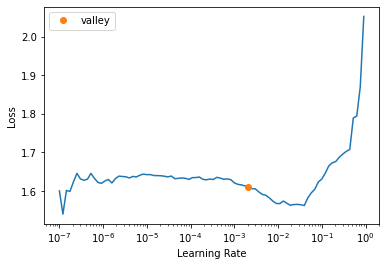

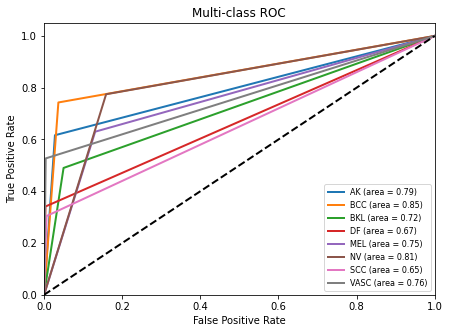

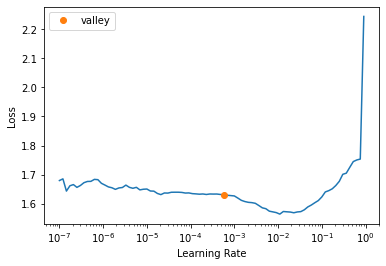

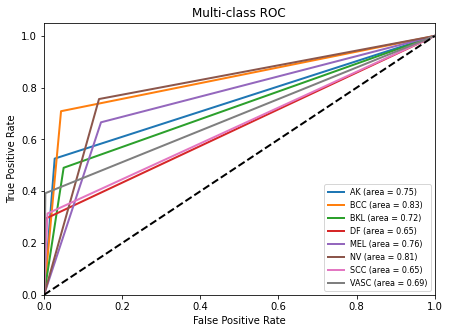

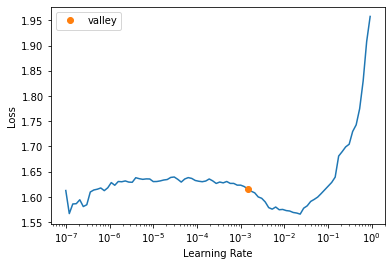

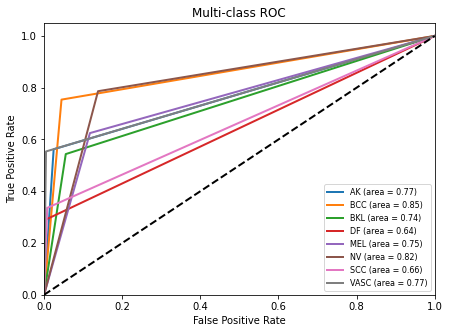

In [33]:
#Hyperparams: description, type of intial weights, number of epochs, number of runs
description = 'BT initial weights, 40 epochs'
initial_weights='bt_pretrain'
epochs=40
runs=3

tune_model_path = save_directory + f'/initial_weights={initial_weights}'
dict_path = f'{initial_weights}' #file to load dictionary metadata

bt_results = main_tune(initial_weights,epochs=epochs,device=device, tune_model_path=tune_model_path, dict_path = dict_path,description=description,
          runs=runs
          )

# Mean classification report for supervised weights:

In [127]:
#sup_results=load_dict_from_gdrive(save_directory,'sup_results') #how to load
mean_sup_results = Mean_Results(sup_results)

              precision    recall  f1-score   support

          AK       0.36      0.57      0.44     498.0
         BCC       0.69      0.76      0.72    2549.0
         BKL       0.46      0.50      0.48    1663.0
          DF       0.31      0.31      0.31     173.0
         MEL       0.49      0.62      0.55    3339.0
          NV       0.85      0.68      0.76   10601.0
         SCC       0.35      0.32      0.33     414.0
        VASC       0.21      0.71      0.31     186.0

    accuracy                           0.65   19423.0
   macro avg       0.47      0.56      0.49   19423.0
weighted avg       0.70      0.65      0.67   19423.0

mean acc is 0.6520619789759318 with std 0.008763411299449422


In [108]:
sup_results.keys()

dict_keys([0, 1, 2])

# Mean classification report for self-supervised weights:

In [128]:
#bt_results=load_dict_from_gdrive(save_directory,'bt_results') #how to load 
mean_bt_results = Mean_Results(bt_results)

              precision    recall  f1-score   support

          AK       0.36      0.57      0.44     498.0
         BCC       0.73      0.74      0.73    2549.0
         BKL       0.48      0.51      0.49    1663.0
          DF       0.46      0.31      0.37     173.0
         MEL       0.50      0.64      0.56    3339.0
          NV       0.86      0.77      0.82   10601.0
         SCC       0.47      0.32      0.38     414.0
        VASC       0.54      0.49      0.51     186.0

    accuracy                           0.70   19423.0
   macro avg       0.55      0.54      0.54   19423.0
weighted avg       0.72      0.70      0.71   19423.0

mean acc is 0.700544019540151 with std 0.011334401735863859


# Let's explore whether pretraining a second time helps performance (pre-pre training)

In [100]:
len(_fnames) == len(fnames_train)+len(fnames_valid)+len(fnames_test) #test

True

In [102]:
#Set the training dataloader for BT equal to all the available data
_fnames_train = _fnames
dls_train  = ImageDataLoaders.from_path_func(directory,_fnames_train, label_func,
                                bs=128,
                                item_tfms=item_tfms_train,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda')
                                             )

Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,time
0,398.648163,None,02:24


/usr/local/lib/python3.9/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


0.0002754228771664202


epoch,train_loss,valid_loss,time
0,313.223969,None,01:58
1,293.590240,None,01:57
2,275.731049,None,01:57
3,248.366608,None,01:57
4,221.718307,None,01:57
5,198.122620,None,01:57
6,181.172546,None,01:57
7,164.982544,None,01:57
8,153.938614,None,01:57
9,145.033981,None,01:57


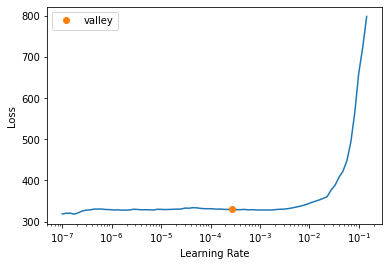

In [103]:
bt_model,_ = create_model('bt_pretrain',device)
learn = Learner(dls_train,bt_model,splitter=my_splitter_bt,cbs=[BarlowTwins(aug_pipelines,n_in=3,lmb=1/8192,print_augs=False)])

learn.freeze()
#learn.summary() #You can call this block to verify that the the encoder is being frozen
learn.fit(1)
learn.unfreeze()
lrs = learn.lr_find()
print(lrs.valley)
learn.fit_one_cycle(50,lrs.valley)

# Fine tune pre-pretrained model

Description: We pretrained BT initial weights on whole dataset (train and test)

The general tune model path is: /content/drive/My Drive/cancer_colab/initial_weights=bt_prepretrained (if None mean no saving)
The dict_path is: bt_prepretrained
tune_model_path for this run is: /content/drive/My Drive/cancer_colab/initial_weights=bt_prepretrained_run0
Froze head


epoch,train_loss,valid_loss,time
0,1.636422,None,00:17


Unfroze head


Learning rate finder yielded lr_max: 0.0004786300996784121


epoch,train_loss,valid_loss,time
0,1.419756,None,00:17
1,1.400727,None,00:18
2,1.371248,None,00:18
3,1.326311,None,00:18
4,1.268302,None,00:17
5,1.194372,None,00:17
6,1.109633,None,00:17
7,1.005539,None,00:17
8,0.900202,None,00:17
9,0.786875,None,00:17


We are saving after true epoch 40 at path /content/drive/My Drive/cancer_colab/initial_weights=bt_prepretrained_run0
              precision    recall  f1-score   support

          AK       0.36      0.58      0.44       498
         BCC       0.70      0.77      0.74      2549
         BKL       0.45      0.54      0.49      1663
          DF       0.28      0.38      0.33       173
         MEL       0.57      0.62      0.60      3339
          NV       0.88      0.79      0.83     10601
         SCC       0.51      0.34      0.41       414
        VASC       0.47      0.45      0.46       186

    accuracy                           0.71     19423
   macro avg       0.53      0.56      0.54     19423
weighted avg       0.74      0.71      0.72     19423

0.7139473557472229
We are saving the dictionary at bt_prepretrained


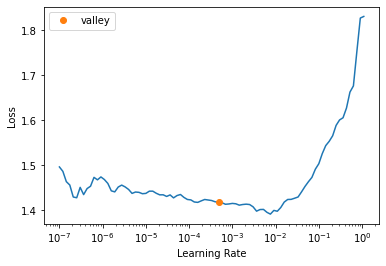

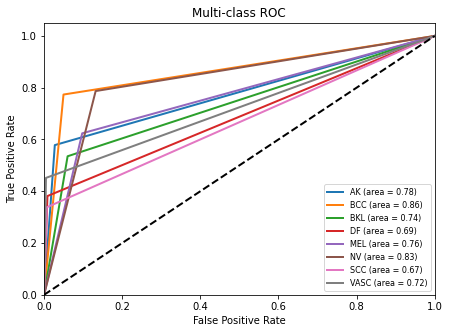

In [104]:
description = 'We pretrained BT initial weights on whole dataset (train and test)'
initial_weights='bt_prepretrained' #pretrain again, hence `prepre`
epochs=40
runs=1

tune_model_path = save_directory + f'/initial_weights={initial_weights}'
dict_path = f'{initial_weights}' #file to load dictionary metadata

bt_results = main_tune(initial_weights='na',epochs=epochs,device=device, tune_model_path=tune_model_path, dict_path = dict_path,description=description,
          runs=runs,
          encoder=learn.model.encoder
          )

Conclusion: doesn't seem to help.